# Cluster Lens Simulation Interface

This notebook shows the current progress in the group and cluster scale simulations.

Implemented:
* NFWCluster deflector class: a NFW halo and EPL subhalos
* Integration with Lens interface to simulate lens related quanities.
* Use cluster catalog to build a cluster lens population
* Generate a cluster lens population with LensPop

Not yet implemented:
* Realistic halo population based on halo mass distribution instead of catalogs

## Setup

In [1]:
import slsim.Sources as sources
import slsim.Pipelines as pipelines
import slsim.Deflectors as deflectors

from slsim.Lenses.lens_pop import LensPop
from slsim.Lenses.lens import Lens

from slsim.Plots.lens_plots import LensingPlots

import numpy as np
import matplotlib.pyplot as plt
from astropy.units import Quantity
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table

Generate a population of sources and red galaxies to be used as cluster members

In [2]:
np.random.seed(1)

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

sky_area = Quantity(value=0.05, unit="deg2")

kwargs_deflector_cut = {"band": "g", "band_max": 22, "z_min": 0.2, "z_max": 1.0}
kwargs_source_cut = {"band": "g", "band_max": 22, "z_min": 0.21, "z_max": 5.0}

galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None,
    sky_area=sky_area,
    filters=None,
)
source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=sky_area,
    catalog_type="skypy",
)

Load a cluster catalog. This is an example of a few clusters from redMaPPer

In [4]:
cluster_catalog = Table.read("../data/redMaPPer/clusters_example.fits")
members_catalog = Table.read("../data/redMaPPer/members_example.fits")

Cluster has redshift and richness. A NFW halo is used to describe its mass based on a mass-richness relation.

In [5]:
cluster_catalog[:20]

cluster_id,richness,z
int16,float32,float32
266,44.300,0.7447
356,33.640,0.4202
217,53.090,0.4392
139,72.940,0.4462
991,30.160,0.7852
409,36.520,0.5048
7,82.550,0.2999
150,45.040,0.4306
157,41.990,0.5563


We use real members to distribute the subhalos. To each member we assign a SkyPyPipeline red galaxy based on magnitudes and redshift to build EPL subhalos.

56


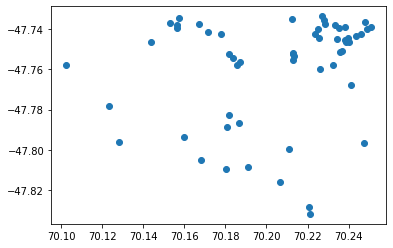

In [6]:
members_ =  members_catalog[members_catalog["cluster_id"] == 7]
print(len(members_))


plt.plot(members_['ra'], members_['dec'], 'o')
plt.show()

In [7]:
lens_clusters = deflectors.ClusterDeflectors(
    cluster_list=cluster_catalog,
    members_list=members_catalog,
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=sky_area,
    kwargs_draw_members = {"max_dist": 1000}
)

/Users/sibirrer/Software/LSST-strong-lensing/slsim/slsim/Deflectors/DeflectorPopulation/cluster_deflectors.py:71: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  galaxy_list = param_util.catalog_with_angular_size_in_arcsec(


Number of cluster members 50


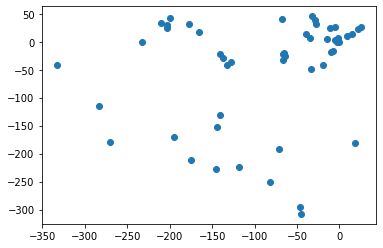

cluster_id member_id      ra     ...        e2_mass         n_sersic gamma_pl
                                 ...                                         
---------- ---------- ---------- ... ---------------------- -------- --------
         7 2929088686  70.210811 ...  -0.014675927973383823      4.0      2.0
         7 2929089143  70.247586 ...  -0.051885737485912055      4.0      2.0
         7 2929090333  70.181914 ...   -0.08017415054352832      4.0      2.0
         7 2929092478  70.226195 ...   0.057299152474997575      4.0      2.0
         7 2929092787  70.232244 ...    0.14990263434719914      4.0      2.0
         7 2929092925  70.185466 ...  -0.005175053372989371      4.0      2.0
         7 2929092959  70.187237 ...  -0.018338730100079387      4.0      2.0
         7 2929093054  70.212898 ...  -0.038021874359028006      4.0      2.0
         7 2929093055  70.183605 ...  -0.017886759157175417      4.0      2.0
       ...        ...        ... ...                    ...     

In [8]:
cluster_members = lens_clusters.draw_members(cluster_id=7, max_dist=10000)
print("Number of cluster members", len(cluster_members))

plt.plot(cluster_members["center_x"], cluster_members["center_y"], 'o')
plt.show()
print(cluster_members)


cluster_class = lens_clusters.draw_deflector(index=7)

In [9]:
lenspop = LensPop(
    deflector_population=lens_clusters,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area,
)

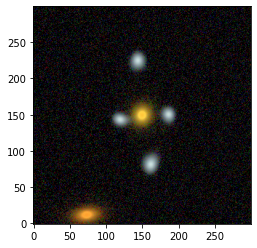

In [10]:
cluster_lens_plot = LensingPlots(lenspop, num_pix=300, coadd_years=10)

source_class = source_galaxies.draw_source(z_max=None, z_min=1, galaxy_index=None)


lens_cluster_class = Lens(source_class=source_class, deflector_class=cluster_class, cosmo=cosmo)
kwargs_model, kwargs_params = lens_cluster_class.lenstronomy_kwargs(band="i")

image_rgb = cluster_lens_plot.rgb_image(lens_class=lens_cluster_class, rgb_band_list=["i", "r", "g"])
plt.imshow(image_rgb, origin="lower")
plt.show()

## Generate images of random lenses

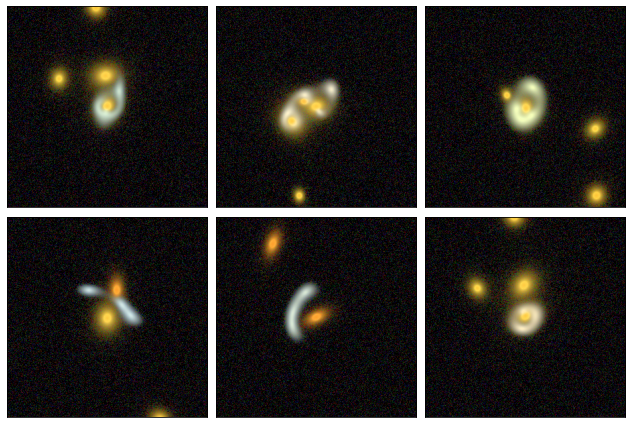

In [11]:
# make some cuts in the image separations and limited magnitudes of the arc
kwargs_lens_cut_plot = {
    "min_image_separation": 2.0,
    "max_image_separation": 30.0,
    #"mag_arc_limit": {"g": 22, "r": 22, "i": 22},
}


# generate montage indicating which bands are used for the rgb color image
fig, axes = cluster_lens_plot.plot_montage(
    rgb_band_list=["i", "r", "g"],
    add_noise=True,
    n_horizont=3,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
plt.show()